In [16]:
import warnings
warnings.filterwarnings("ignore")

In [17]:
import cv2
import detectron2
import json
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import torch

from detectron2 import model_zoo
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.config import get_cfg, instantiate
from detectron2.data import MetadataCatalog
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score
from sklearn.metrics import silhouette_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from umap import UMAP

In [18]:
def show(img, title='', bgr2rgb=True):
    plt.title(title)
    plt.xticks([])
    plt.yticks([])
    if bgr2rgb and img.ndim == 3:
        plt.imshow(img[...,::-1])
    else:
        plt.imshow(img)
    plt.show()

## Функция для извлечения гистограмм, а также оценка тестовых гистрограмм

In [19]:
def hists_extractor(data, n_hists=5, mode='train', model=None):
    features = []
    all_acc = []
    
    for file_name in data:
        img = cv2.imread(f'team_classification_{mode}/frames/{file_name}.jpeg')
        
        y_true = []
        y_pred = []
        
        for player in data[file_name]:
            # Извлечение изображение из bbox'а
            x, y, w, h = data[file_name][player]['box']
            x, y, w, h = int(x*img.shape[1]), int(y*img.shape[0]), int(w*img.shape[1]), int(h*img.shape[0])
            if x < 0 : x=0
            if y < 0 : y=0
            img_in_bbox = img[y:y+h,x:x+w]
            
            # Сегментирование силуэтов для удаления фона
            outputs = segmentator(img_in_bbox, viz=False)
            mask = np.zeros(img_in_bbox.shape[:2], dtype=np.uint8)
            for m, l in zip(outputs["instances"].pred_masks,outputs["instances"].pred_classes):
                if l.item() == 0:
                    mask += m.cpu().numpy()

            x, y = img_in_bbox[mask.astype(bool)].shape

            # Построение гистограмм для каждого канала, по извлеченным маской пикселям
            hists_by_channels = []
            for i in range(3):
                histr = cv2.calcHist([img_in_bbox[mask.astype(bool)].reshape(x, 1, y)],
                                     [i],None,[n_hists],[0,256])
                hists_by_channels.append(histr/img_in_bbox.size)
            
            # Если выбран тренировочный режим, просто записываем фичи
            if mode == 'train':
                features.append(np.array(hists_by_channels).ravel())
            
            # Если выбран тестовый режим, то запишем предсказанные и истинные метки
            elif mode == 'test':
                gist2vec = np.array(hists_by_channels).ravel().reshape(1, -1)
                y_true.append(data[file_name][player]['team'])
                y_pred.append(int(model.predict(gist2vec)))
        
        # Оценим точность, если выбран тестовый режим
        if mode == 'test':
            acc = accuracy_score(y_true, y_pred)
            all_acc.append(acc if acc >= 0.5 else 1 - acc)
    
    if mode == 'train':
        return features
    
    elif mode == 'test':
        return np.mean(all_acc)

In [20]:
 class SegmentatorNewBaseline:
    def __init__(self, model_name, threshold=0.5):
        print ('Using model', model_name)
        
        # Get model config and weights (download if it doesn't exist):
        self.cfg = model_zoo.get_config(model_name, trained=True)
        self.cfg['model']['roi_heads']['box_predictor']['test_score_thresh'] = threshold
        
        # Init:
        self.model = instantiate(self.cfg.model)
        
        # Load a checkpoint:
        DetectionCheckpointer(self.model).load(self.cfg.train.init_checkpoint)
        
        self.model.eval()
        self.model.to('cuda')

    def __call__(self, img, viz=False):
        # Preprocess input image:
        img_tensor = torch.from_numpy(img)
        img_tensor = torch.permute(img_tensor, (2, 0, 1))
        batch = [{"image": img_tensor.to('cuda')}]
        
        # Inference:
        with torch.no_grad():
            outputs = self.model(batch)[0]

        # Vizualize:
        if viz:
            v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(self.cfg['dataloader']['train']['dataset']['names']), scale=3)
            img = v.draw_instance_predictions(outputs["instances"].to("cpu")).get_image()
            plt.imshow(img)
            plt.show()

        return outputs

In [21]:
segmentator = SegmentatorNewBaseline('new_baselines/mask_rcnn_R_101_FPN_400ep_LSJ.py', 0.4)

Using model new_baselines/mask_rcnn_R_101_FPN_400ep_LSJ.py


In [22]:
f = open('team_classification_train/bboxes.json')
data = json.load(f)
features = hists_extractor(data)
df = pd.DataFrame(np.array(features))

## Тестирование некоторых алгоритмов кластеризаци

In [23]:
# Используем StandardScaler для нормализации данных.
scaler = StandardScaler()
scaled_data = pd.DataFrame(
    data=scaler.fit_transform(df), 
    columns=df.columns
)

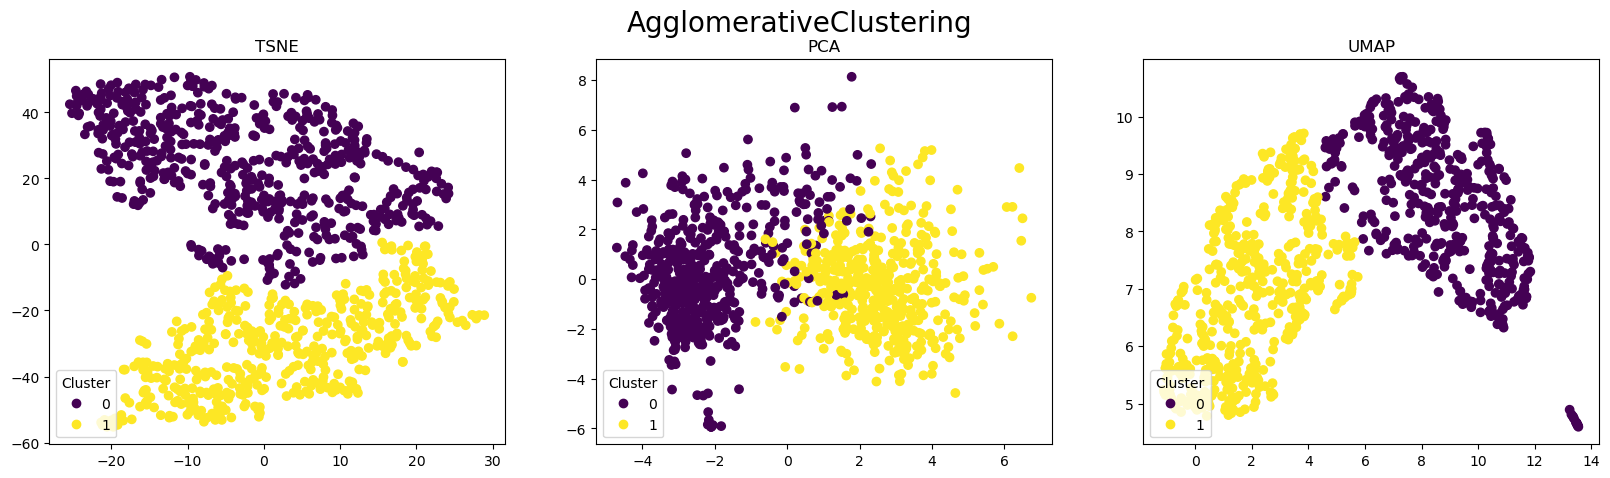

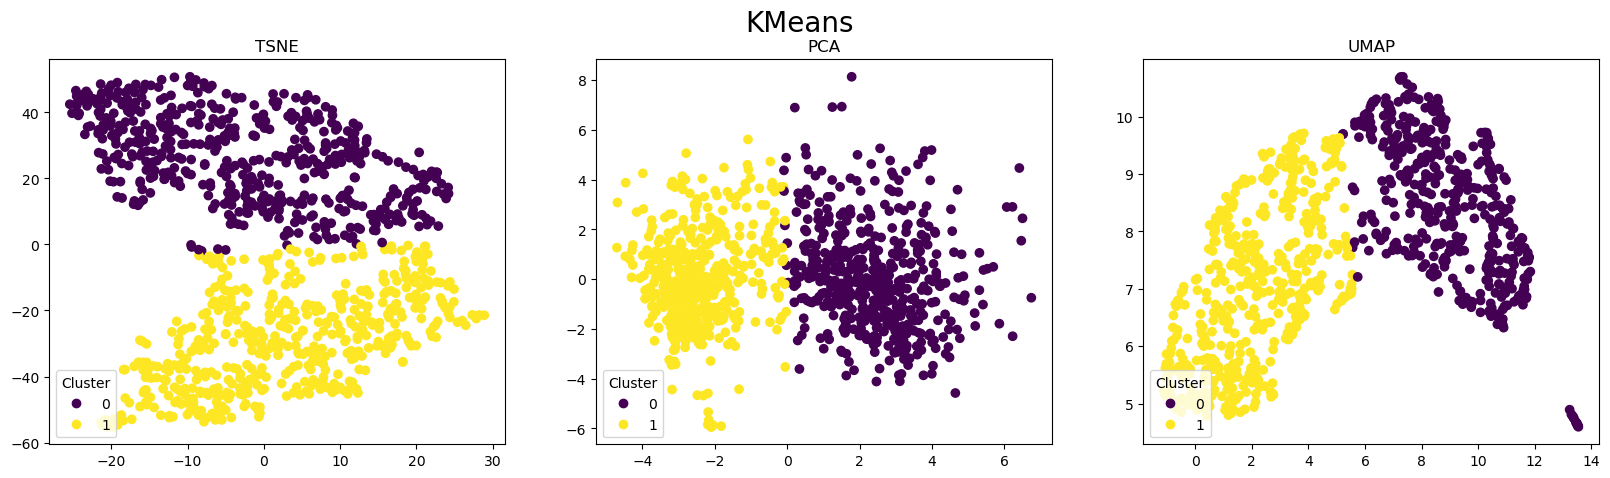

In [24]:
clustering_algorithms = [AgglomerativeClustering, KMeans]
df_labels = pd.DataFrame()

for algorithm in clustering_algorithms:
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    for ind, dim_reducer in enumerate([TSNE, PCA, UMAP]):
        dim_reduced_data = dim_reducer(random_state=42).fit_transform(scaled_data)
        
        model = algorithm(n_clusters=2).fit(dim_reduced_data)
        labels = model.labels_
        df_labels[algorithm.__name__+"_"+dim_reducer.__name__] = model.labels_
        plt.suptitle(algorithm.__name__, fontsize=20)
        scatter = axes[ind].scatter(dim_reduced_data[:, 0], dim_reduced_data[:, 1], c=labels)
        axes[ind].set_title(dim_reducer.__name__)
        legend = axes[ind].legend(*scatter.legend_elements(),
                    loc="lower left", title="Cluster")

 ## Попробуем AgglomerativeClustering

In [25]:
model = AgglomerativeClustering(n_clusters=2).fit(dim_reduced_data)
df['team'] = model.labels_
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,team
0,0.016190,0.032191,0.041585,0.014945,0.015784,0.013456,0.010369,0.030296,0.043860,0.022715,0.009016,0.008880,0.019222,0.036062,0.047515,1
1,0.013842,0.025142,0.028623,0.016452,0.003133,0.005813,0.022752,0.027764,0.026569,0.004293,0.003597,0.012066,0.022787,0.036884,0.011858,1
2,0.023108,0.046517,0.034071,0.021886,0.012366,0.017617,0.036115,0.029421,0.034492,0.020302,0.010422,0.025693,0.034933,0.035273,0.031626,1
3,0.063134,0.041649,0.010989,0.006516,0.011007,0.065089,0.027666,0.021150,0.009334,0.010056,0.056847,0.020939,0.027050,0.013771,0.014687,0
4,0.022546,0.033320,0.024615,0.025437,0.022515,0.022681,0.016400,0.029170,0.035691,0.024491,0.020352,0.012459,0.015589,0.037708,0.042326,1


## Модель для классификации игроков

In [26]:
neigh = KNeighborsClassifier(n_neighbors=7)
neigh.fit(df.drop(['team'], axis=1), df['team'])

KNeighborsClassifier(n_neighbors=7)

## Оценка на тестовых данных

In [27]:
f = open('team_classification_test/gt_bboxes.json')
data = json.load(f)

In [28]:
acc = hists_extractor(data, mode='test', model=neigh)
print(acc)

0.8860000000000001
